In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
results_per_scene = dict()

In [22]:
scene_name = "berlin"
metric = "psnr"
local = False
alt = ""
local_text = "_local" if local else ""
log_dir = f"../tensorboard_results/{scene_name}{alt}{local_text}/{metric}"

In [11]:
global_training_times = {
    "bicycle": {
    100: 3.0,
    500: 14.2,
    1000: 27.9,
    2000: 55.6,
    10000: 259.5
},
    "counter": {
    100: 5.6,
    500: 16.9,
    1000: 30.9,
    2000: 59.3,
    10000: 268.0
},
    "berlin": {
    1000: 30.1,
    2000: 58.1,
    5000: 134.7,
    10000: 260.3
},
    "nyc": {
    1000: 31.49,
    2000: 59.35,
    5000: 135.27,
    10000: 261.06
},
    "london": {
    1000: 35.34
},
    "alameda": {
    1000: 36.97
},
    "bonsai": {
    100: 6.86,
    500: 17.71,
    1000: 32.13,
    2000: 59.68,
    10000: 264.24
},
    "garden": {
    100: 4.19,
    500: 15.36,
    1000: 29.06,
    2000: 56.59,
    10000: 258.29
},
    "stump": {
    100: 3.36,
    500: 14.24,
    1000: 28.19,
    2000: 56.14,
    10000: 259.71
}
}

In [12]:
local_training_times_by_scene = {
    "berlin": {
    200: 5.78 + 5.57 + 5.68 + 5.58 + 5.63,
    1000: 27.79 + 27.87 + 27.89 + 27.87 + 27.69,
    2000: 55.60 + 55.16 + 56.08 + 56.00 + 55.47,
    5000: 132.34 + 131.59 + 130.79 + 132.46 + 131.65,
    10000: 255.00 + 254.43 + 253.70 + 254.41 + 254.09,
    "1000_merged": 29.09
},
    "nyc": {
    200: 5.89 + 5.67 + 6.00 + 5.83 + 6.06,
    1000: 28.24 + 27.60 + 27.89 + 27.91 + 27.26,
    2000: 57.28 + 55.26 + 55.74 + 54.85 + 55.43,
    "1000_merged": 30.11
},
    "london": {
    "1000_merged": 30.14
},
    "alameda": {
        "1000_merged": 30.30
    }
}

In [35]:
training_times_by_global_nerf_iterations = global_training_times[scene_name] if scene_name in global_training_times else {}
training_times_by_local_nerf_iterations = local_training_times_by_scene[scene_name] if scene_name in local_training_times_by_scene else {}
training_times = dict()

metrics = []
name_map = dict()
for root, dirs, files in os.walk(log_dir):
    for file in files:
        if ".csv" in file:
            if scene_name == "berlin" and "100k" in file:
                continue
            print(f"Processing: {root}/{file}")
            metrics_df = pd.read_csv(os.path.join(root, file))
            experiment_name = os.path.relpath(file, log_dir).split("/")[-1].replace(".csv", "").split("splatfacto_")[-1]
            experiment_name = experiment_name.replace("1mil", "1000000").replace("1m", "1000000").replace("1k", "1000").replace("0k", "0000").replace("add_", "")
            metrics_df['experiment'] = experiment_name
            metrics.append(metrics_df)
            if ("merged_sfm" in experiment_name) or ("sfm_global" in experiment_name):
                # Find values using regex
                pattern = r'(\d+)its_(\d+)pts_(\d+)_its'
                match = re.search(pattern, experiment_name)
                if match:
                    nerf_iterations = int(match.group(1))
                    points = int(match.group(2))
                    gs_iterations = int(match.group(3))
                    name_map[experiment_name] = f"Global NeRF ({nerf_iterations}its) + SfM ({points} pts)"
                    training_times[name_map[experiment_name]] = training_times_by_global_nerf_iterations[nerf_iterations]
                else:
                    pattern = r'(\d+)its_(\d+)_'
                    match = re.search(pattern, experiment_name)
                    if match:
                        nerf_iterations = int(match.group(1))
                        points = int(match.group(2))
                        # name_map[experiment_name] = f"Global NeRF ({nerf_iterations}its) + SfM ({points} pts)"
                        name_map[experiment_name] = f"Global NeRF ({nerf_iterations}its) + SfM"
                        training_times[name_map[experiment_name]] = training_times_by_global_nerf_iterations[nerf_iterations]
                    else:
                        name_map[experiment_name] = experiment_name
                        print(f"No match found for {experiment_name} with pattern {pattern}")
            elif "sparse_pc_densified" in experiment_name:
                name_map[experiment_name] = "SfM (Added points)"
            elif "sparse_pc" in experiment_name:
                name_map[experiment_name] = "SfM"
            elif (("local_merged" in experiment_name) or ("merged_local" in experiment_name)) and ("1000" in experiment_name):
                name_map[experiment_name] = "Local NeRFs (1000its) + SfM"
                training_times[name_map[experiment_name]] = training_times_by_local_nerf_iterations["1000_merged"]
            elif "local_nerf" in experiment_name:
                pattern = r'(\d+)its_(\d+)'
                match = re.search(pattern, experiment_name)
                if match:
                    nerf_iterations = int(match.group(1))
                    points = int(match.group(2))
                    name_map[experiment_name] = f"Local NeRFs ({nerf_iterations}its, {points} pts) + SfM"
                    training_times[name_map[experiment_name]] = training_times_by_local_nerf_iterations[nerf_iterations]
                else:
                    name_map[experiment_name] = experiment_name
                    print(f"No match found for {experiment_name}")
            elif "global_nerf" in experiment_name:
                pattern = r'(\d+)its_(\d+)_'
                match = re.search(pattern, experiment_name)
                if match:
                    nerf_iterations = int(match.group(1))
                    points = int(match.group(2))
                    name_map[experiment_name] = f"Global NeRF ({nerf_iterations}its, {points} pts)"
                    training_times[name_map[experiment_name]] = training_times_by_global_nerf_iterations[nerf_iterations]
                else:
                    name_map[experiment_name] = experiment_name
                    print("No match found.")
            elif "nerf" in experiment_name:
                pattern = r'(\d+)_iters'
                match = re.search(pattern, experiment_name)
                if match:
                    nerf_iterations = int(match.group(1))
                    name_map[experiment_name] = f"Global NeRF ({nerf_iterations}its) only"
                    training_times[name_map[experiment_name]] = training_times_by_global_nerf_iterations[nerf_iterations]
            else:
                print(f"Unknown experiment name: {experiment_name}")
                name_map[experiment_name] = experiment_name
psnr = pd.concat(metrics)
# Remove datapoints at steps 3k, 6k, 9k, 12k, 15k, 18k (below 20k) [only for plotting]
# psnr = psnr[(psnr['Step'] % 3000 != 0) | (psnr['Step'] >= 20000)]

Processing: ../tensorboard_results/berlin/psnr/splatfacto_sfm_local_merged_all_clean_1000its_600k_30000_its.csv
Processing: ../tensorboard_results/berlin/psnr/splatfacto_sparse_pc_30000_its.csv
Processing: ../tensorboard_results/berlin/psnr/splatfacto_sfm_global_nerf_1000its_600k_30000_its.csv


In [33]:
#psnr
# Only keep exeriments sparse_pc_30000_its and all that contain "150000pts"
# psnr = psnr[psnr['experiment'].str.contains("sparse_pc_30000_its|150000pts", regex=True)]
# Remove experiments containing "500its" or "2000its"
psnr = psnr[~psnr['experiment'].str.contains("100k|500its|2000its", regex=True)]
# Rename experiments containing "(600000 pts)", removing the phrase
print([name_map[exp] for exp in psnr['experiment'].unique()])

['Global NeRF (1000its) + SfM', 'Local NeRFs (1000its) + SfM', 'SfM', 'Global NeRF (1000its) + SfM', 'Local NeRFs (1000its, 100000 pts) + SfM']


In [31]:
def plot_psnr(psnr, experiments, by="time", baseline_experiment="SfM", metric="psnr"):
    """
    Plot the PSNR values for each experiment and a barplot for final PSNR values,
    with a scaled y-axis in the barplot. Experiment display names are provided via a dictionary.

    Args:
        psnr (pd.DataFrame): DataFrame containing PSNR values with columns ['Step', 'Value', 'experiment'].
        experiments (dict): Dictionary mapping experiment keys to display names.
    """
    best_within_baseline_d = dict()

    # Filter PSNR data for selected experiments
    filtered_psnr = psnr[psnr['experiment'].isin(experiments.keys())]

    # Map experiment names to display names using .assign()
    filtered_psnr = filtered_psnr.assign(
        experiment_display=filtered_psnr['experiment'].map(experiments)
    )

    # Ensure the bar plot follows the order in the experiments dictionary
    filtered_psnr['experiment_display'] = pd.Categorical(
        filtered_psnr['experiment_display'],
        categories=list(experiments.values()),
        ordered=True
    )

    # Rename Wall time to Time
    filtered_psnr = filtered_psnr.rename(columns={"Wall time": "Time"})
    metric_name = {
        "psnr": "PSNR",
        "ssim": "SSIM",
        "gaussian_counts": "Number of Gaussians",
    }[metric]

    # Line plot for PSNR over by
    x = "Step" if by == "step" else "Time"
    plt.figure(figsize=(8, 6))
    if baseline_experiment is not None and baseline_experiment.lower() in [exp.lower() for exp in experiments.values()]:
        best_baseline_psnr = filtered_psnr[filtered_psnr['experiment_display'].str.lower() == baseline_experiment.lower()]['Value'].max()
        baseline_time = filtered_psnr[filtered_psnr['experiment_display'].str.lower() == baseline_experiment.lower()]['Time'].max() - filtered_psnr[filtered_psnr['experiment_display'].str.lower() == baseline_experiment.lower()]['Time'].min()
        print(f"baseline time {baseline_time}")
    for experiment, group in filtered_psnr.groupby('experiment_display', observed=True):
        # Convert Time to Time in seconds since the start of the experiment
        if by == "time":
            startup_time = training_times[experiment] if experiment in training_times else 0.0
            group[x] = (group[x] - group[x].min() + startup_time)
        experiment_plot = plt.plot(group[x], group['Value'], label=experiment)
        if metric != "gaussian_counts":
            if baseline_experiment is not None and experiment.lower() == baseline_experiment.lower():
                plt.axhline(y=best_baseline_psnr, color=experiment_plot[0].get_color(), linestyle='--', label=f"Best {baseline_experiment} {metric_name}")
            # Add vertical lines where each experiment reaches the baseline PSNR for the first time
            if baseline_experiment is not None:
                baseline_psnr = group[group['Value'] >= best_baseline_psnr]
                # Final PSNR value at the max time of the baseline experiment
                # The best PSNR value within the time range of the baseline experiment
                best_value_within_baseline_time = group[group[x] <= baseline_time]['Value'].max()
                best_within_baseline_d[experiment] = best_value_within_baseline_time
                if not baseline_psnr.empty:
                    first_x = baseline_psnr[x].iloc[0]
                    print(first_x)
                    plt.axvline(x=first_x, color=experiment_plot[0].get_color(), linestyle='--')
                                #, label=f"{experiment} reaches {baseline_experiment} PSNR")
                    # plt.text(first_x, best_baseline_psnr, f"{first_x:.2f}", color=experiment_plot[0].get_color(), ha='right', va='bottom')
                else:
                    print(f"{experiment} never reaches the baseline {metric_name} of {best_baseline_psnr}.")

    plt.xlabel("Step" if by == "step" else "Time in seconds")
    plt.ylabel(f"{metric_name}")
    scene_display_name = scene_name.capitalize()
    local_tag = "Local" if local else "Global"
    if metric != "gaussian_counts":
        plt.title(f"{metric_name} vs. {'Step' if by == 'step' else 'Time in seconds'} on {scene_display_name} ({local_tag} Evaluation)")
    else:
        plt.title(f"{metric_name} vs. {'Step' if by == 'step' else 'Time in seconds'} on {scene_display_name}")
    plt.legend(title="Experiments")
    plt.grid()
    plt.show()

    # Bar plot for final PSNR values
    final_psnr = (
        filtered_psnr.groupby('experiment_display', observed=True)['Value']
        .last()
        .reset_index()
    )

    # Determine y-axis range based on min and max PSNR
    y_min = final_psnr['Value'].min() * 0.95  # Slightly below the minimum
    y_max = final_psnr['Value'].max() * 1.05  # Slightly above the maximum

    plt.figure(figsize=(12, 6))
    bars = plt.bar(final_psnr['experiment_display'], final_psnr['Value'], color='skyblue')
    plt.ylim(y_min, y_max)  # Scale the y-axis based on min and max
    plt.xlabel("Experiment")
    plt.ylabel(f"Final {metric_name}")
    plt.title(f"Final {metric_name} for Each Experiment")
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add value annotations to bars
    for bar, value in zip(bars, final_psnr['Value']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{value:.2f}", ha='center', va='top', fontsize=10)

    plt.tight_layout()
    plt.show()
    return best_within_baseline_d

baseline time 1248.112944841385
1208.143236722946
1235.9217360019684
1238.8142107486724


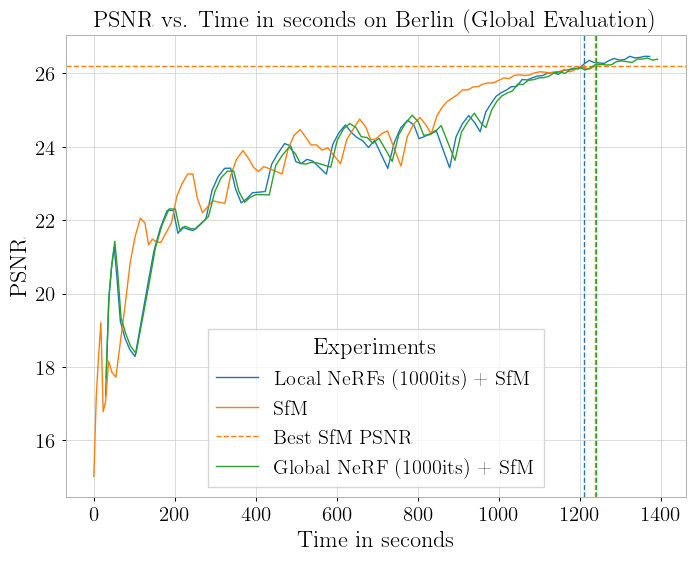

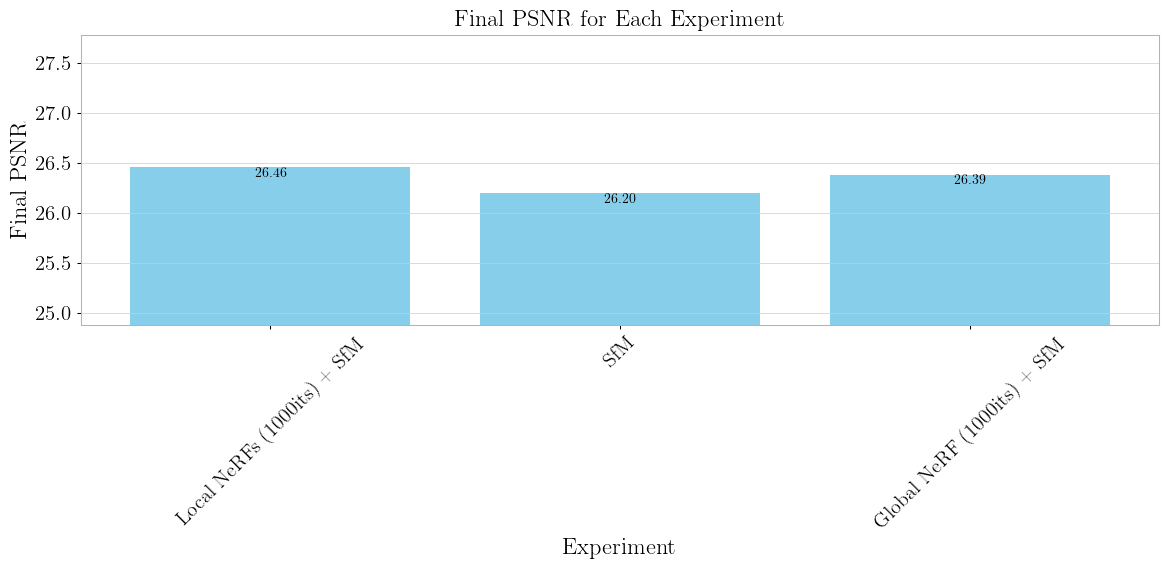

                    Experiment  Best psnr within Baseline Time
0  Local NeRFs (1000its) + SfM                       26.354136
1                          SfM                       26.204048
2  Global NeRF (1000its) + SfM                       26.251106


In [36]:
with plt.rc_context(fname="style.rc"):
    best_within_baseline = plot_psnr(psnr, name_map, by="time", metric=metric)
    best_within_time_df = pd.DataFrame(best_within_baseline.items(), columns=["Experiment", f"Best {metric} within Baseline Time"])
    print(best_within_time_df)
    # Store the results for each scene
    results_per_scene[scene_name + alt] = best_within_time_df
    #plot_psnr(psnr, name_map, by="step")
#plot_psnr(psnr, {"sfm": "SfM", "local_500": "Local NeRFs (500its) + SfM", "local_1000": "Local NeRFs (1000its) + SfM", "local_3000": "Local NeRFs (3000its) + SfM", "local_5000": "Local NeRFs (5000its) + SfM", })
#plot_psnr(psnr, {"sfm": "SfM", "global_sfm_1000": "Global NeRF (1000its) + SfM", "global_sfm_5000": "Global NeRF (5000its) + SfM", "global_sfm_20000": "Global NeRF (20000its) + SfM"})

In [23]:
# Rename keys (remove underscores)
results_per_scene = {key.split("_")[0]: value for key, value in results_per_scene.items()}
results_per_scene

{'bicycle':                                    Experiment  Best psnr within Baseline Time
 0    Global NeRF (1000its) + SfM (150000 pts)                       25.740677
 1   Global NeRF (10000its) + SfM (150000 pts)                       25.884737
 2     Global NeRF (500its) + SfM (150000 pts)                       25.725939
 3     Global NeRF (500its) + SfM (100000 pts)                       25.760468
 4      Global NeRF (500its) + SfM (50000 pts)                       25.679821
 5    Global NeRF (10000its) + SfM (50000 pts)                       25.816938
 6     Global NeRF (100its) + SfM (100000 pts)                       25.566586
 7    Global NeRF (2000its) + SfM (100000 pts)                       25.773108
 8     Global NeRF (100its) + SfM (150000 pts)                       25.520102
 9                                         SfM                       25.299191
 10   Global NeRF (2000its) + SfM (150000 pts)                       25.755054
 11  Global NeRF (10000its) + SfM (100000

In [24]:
#results_per_scene = zipnerf_psnr_bak.copy()
#del results_per_scene["alameda"]
#results_per_scene["alameda"] = results_per_scene["alameda_v11"]
#del results_per_scene["alameda_v11"]
# to df with key as column 'scene'output
results_df = pd.concat(results_per_scene, keys=results_per_scene.keys()).reset_index(level=0).rename(columns={"level_0": "scene"})
# Rename "Best psnr within Baseline Time" to "best_value"
results_df = results_df.rename(columns={"Best psnr within Baseline Time": "best_value"})
# Remove methods that don't appear in all scenes
results_df

,scene,Experiment,best_value
0,bicycle,Global NeRF (1000its) + SfM (150000 pts),25.740677
1,bicycle,Global NeRF (10000its) + SfM (150000 pts),25.884737
2,bicycle,Global NeRF (500its) + SfM (150000 pts),25.725939
3,bicycle,Global NeRF (500its) + SfM (100000 pts),25.760468
4,bicycle,Global NeRF (500its) + SfM (50000 pts),25.679821
5,bicycle,Global NeRF (10000its) + SfM (50000 pts),25.816938
6,bicycle,Global NeRF (100its) + SfM (100000 pts),25.566586
7,bicycle,Global NeRF (2000its) + SfM (100000 pts),25.773108
8,bicycle,Global NeRF (100its) + SfM (150000 pts),25.520102
9,bicycle,SfM,25.299191


In [30]:
# MipNerf PSNR
baseline_avg = {                # Only average value provided (no per-scene values)
    "RadSplat": 28.14,
}
baseline_full = {
    "GSplat-7k": {"bicycle": 23.71, "garden": 26.30, "stump": 25.62, "counter": 27.14, "bonsai": 29.66},
    "3DGS MCMC": {"bicycle": 26.15, "garden": 28.16, "stump": 27.80, "counter": 29.51, "bonsai": 32.88},
    "EVER": {"bicycle": 25.34, "garden": 27.46, "stump": 26.41, "counter": 28.91, "bonsai": 32.24}
}

In [498]:
# ZipNerf
baseline_avg = {
    "RadSplat": 26.17,
}
# For baselines with full per-scene values:
baseline_full = {
    "EVER": {"berlin": 27.24, "nyc": 27.93, "alameda": 24.72, "london": 26.49}
}

In [31]:
import pandas as pd
import subprocess
import os
import tempfile
import shutil
from pdf2image import convert_from_path
import numpy as np


output_dir = "tables"

dataset_name = "mipnerf_psnr"
tex_output_name = f"{dataset_name}.tex"
pdf_output_name = f"{dataset_name}.pdf"
png_output_name = f"{dataset_name}.png"

os.makedirs(output_dir, exist_ok=True)

# Rename "scene" to "Scene"
results_df = results_df.rename(columns={"scene": "Scene"})

# Rename experiments based on keywords:
results_df.loc[results_df['Experiment'].str.contains("Global", na=False), 'Experiment'] = "GSplat (Global NeRF + SfA)"
results_df.loc[results_df['Experiment'].str.contains("Local", na=False), 'Experiment'] = "GSplat (Local NeRFs + SfB)"
results_df.loc[results_df['Experiment'].str.contains("SfM", na=False), 'Experiment'] = "GSplat (SfM)"
results_df.loc[results_df['Experiment'].str.contains("SfA", na=False), 'Experiment'] = "GSplat (Global NeRF + SfM)"
results_df.loc[results_df['Experiment'].str.contains("SfB", na=False), 'Experiment'] = "GSplat (Local NeRFs + SfM)"

all_scenes = results_df['Scene'].unique()
num_scenes = len(all_scenes)
exp_scene_counts = results_df.groupby('Experiment')['Scene'].nunique()
common_experiments = exp_scene_counts[exp_scene_counts == num_scenes].index
filtered_df = results_df[results_df['Experiment'].isin(common_experiments)]

# Compute averages
pivot_table = filtered_df.pivot_table(index='Experiment',
                                      columns='Scene',
                                      values='best_value',
                                      aggfunc='max')

# Add the overall average column (computed over the available scenes)
pivot_table['Avg'] = pivot_table.mean(axis=1)
pivot_table = pivot_table.sort_values('Avg', ascending=False)

new_columns = {col: (col.capitalize() if col != 'Avg' else col) for col in pivot_table.columns}
pivot_table.rename(columns=new_columns, inplace=True)

# For baselines that provide only an average value:
for baseline_name, avg_value in baseline_avg.items():
    row_data = {}
    for col in pivot_table.columns:
        row_data[col] = avg_value if col == "Avg" else np.nan  # Only "Avg" is filled.
    pivot_table.loc[baseline_name] = row_data

# For baselines that provide full per-scene values:
for baseline_name, values in baseline_full.items():
    # Adjust keys to match the capitalized scene names.
    adjusted_values = {k.capitalize(): v for k, v in values.items()}
    row_data = {}
    scene_values = []
    for col in pivot_table.columns:
        if col == "Avg":
            continue
        if col in adjusted_values:
            row_data[col] = adjusted_values[col]
            scene_values.append(adjusted_values[col])
        else:
            row_data[col] = np.nan
    # Compute the average from the provided scene values.
    row_data["Avg"] = sum(scene_values) / len(scene_values) if scene_values else np.nan
    pivot_table.loc[baseline_name] = row_data

formatted_table = pivot_table.copy()

# For each column, format numbers to three decimals.
# Underline and bold the maximum (best) value per column.
for col in pivot_table.columns:
    if col == 'Avg':
        best_avg = pivot_table['Avg'].max(skipna=True)
        formatted_table[col] = pivot_table[col].apply(
            lambda x: "" if pd.isna(x) else (f"\\underline{{\\textbf{{{x:.3f}}}}}" if x == best_avg else f"{x:.3f}")
        )
    else:
        max_val = pivot_table[col].max(skipna=True)
        formatted_table[col] = pivot_table[col].apply(
            lambda x: "" if pd.isna(x) else (f"\\underline{{\\textbf{{{x:.3f}}}}}" if x == max_val else f"{x:.3f}")
        )

latex_table = formatted_table.to_latex(escape=False,
                                       caption=f"Best {metric.upper()} within SfM Training Time on MipNerf360 Scenes",
                                       label="tab:best_scores",
                                       bold_rows=True)

# doesn't work and requires manual adjustment
latex_lines = latex_table.splitlines()
new_lines = []
baseline_inserted = False
# The number of columns is the number of table columns plus one for the index.
n_cols = len(formatted_table.columns) + 1

for line in latex_lines:
    if not baseline_inserted and "&" in line:
        first_cell = line.split("&")[0].strip()
        stripped_first_cell = first_cell.replace(r"\underline{", "").replace(r"\textbf{", "").replace("}", "")
        # If "SfM" is not found in the first cell, assume it's a baseline row.
        if "SfM" not in stripped_first_cell:
            new_lines.append(r"\midrule")
            new_lines.append(r"\multicolumn{" + f"{n_cols}" + r"}{c}{\textit{Baseline results (obtained with different training times)}} \\")
            new_lines.append(r"\midrule")
            baseline_inserted = True
    new_lines.append(line)
latex_table = "\n".join(new_lines)

latex_document = r"""
\documentclass{standalone}
\usepackage{booktabs}
\usepackage{caption}
\begin{document}
%s
\end{document}
""" % latex_table

with tempfile.TemporaryDirectory() as tmpdirname:
    tex_file = os.path.join(tmpdirname, "table.tex")
    with open(tex_file, "w") as f:
        f.write(latex_document)

    compile_proc = subprocess.run(
        ["pdflatex", "-interaction=nonstopmode", tex_file],
        cwd=tmpdirname,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )

    pdf_file = os.path.join(tmpdirname, "table.pdf")
    if not os.path.exists(pdf_file):
        print("PDF generation failed. Check your LaTeX installation and the output below:")
        print(compile_proc.stdout.decode('utf-8'))
        print(compile_proc.stderr.decode('utf-8'))
    else:
        shutil.copyfile(tex_file, os.path.join(output_dir, tex_output_name))
        shutil.copyfile(pdf_file, os.path.join(output_dir, pdf_output_name))

        images = convert_from_path(pdf_file)
        if images:
            image = images[0]
            image_output_path = os.path.join(output_dir, png_output_name)
            image.save(image_output_path, "PNG")
            print(f"Files saved:\n- LaTeX: {os.path.join(output_dir, tex_output_name)}\n- PDF: {os.path.join(output_dir, pdf_output_name)}\n- PNG: {image_output_path}")
        else:
            print("Failed to convert PDF to image.")


Files saved:
- LaTeX: tables/mipnerf_psnr.tex
- PDF: tables/mipnerf_psnr.pdf
- PNG: tables/mipnerf_psnr.png


In [27]:
mipnerf_psnr_bak = results_per_scene.copy()

In [412]:
zipnerf_psnr_bak = results_per_scene.copy()

In [28]:
# Save to disk
import pickle
with open("zipnerf_psnr.pkl", "wb") as f:
    pickle.dump(zipnerf_psnr_bak, f)
with open("mipnerf_psnr.pkl", "wb") as f:
    pickle.dump(mipnerf_psnr_bak, f)

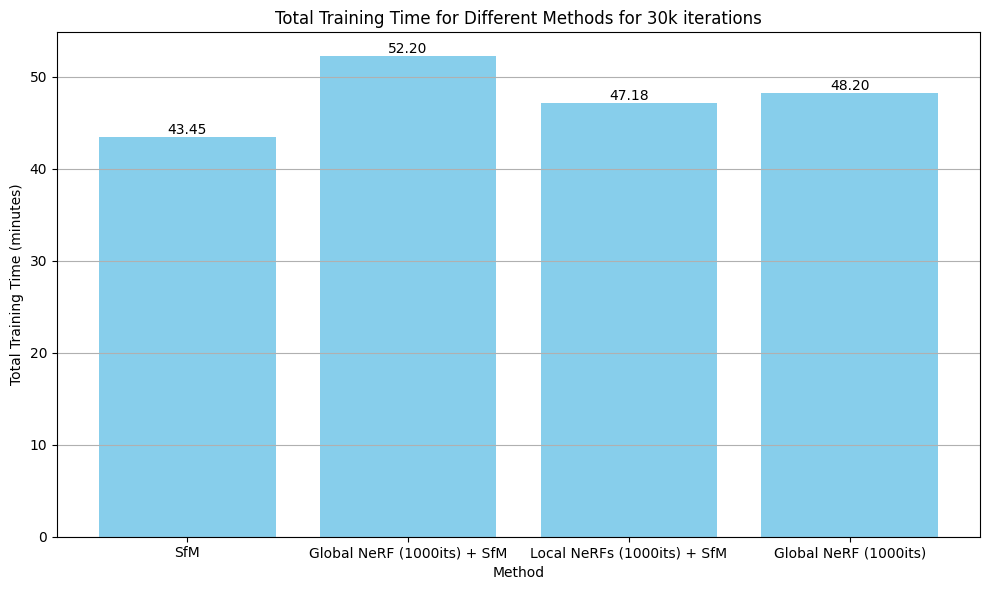

In [338]:
training_times_per_iteration = {
    500: 12.35,
    1000: 24.61,
    3000: 71.69,
    5000: 116.86,
}

gs_times = {
    "SfM": 2607,
    "Global NeRF (1000its) + SfM": 3132,
    "Local NeRFs (1000its) + SfM": 2831,
    "Global NeRF (1000its)": 2892,
}

# to minutes
for key in gs_times:
    gs_times[key] = gs_times[key] / 60.

def plot_training_times(training_times_per_iteration):
    """
    Plot the training times per iteration for different numbers of iterations.

    Args:
        training_times_per_iteration (dict): Dictionary mapping number of iterations to training times.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(list(training_times_per_iteration.keys()), list(training_times_per_iteration.values()), marker='o')
    plt.xlabel("Number of Iterations")
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time per Iteration")
    plt.grid()
    plt.show()

def plot_gs_times(gs_times):
    """
    Plot the total training times for different methods.

    Args:
        gs_times (dict): Dictionary mapping methods to total training times.
    """
    plt.figure(figsize=(10, 6))
    bars = plt.bar(gs_times.keys(), gs_times.values(), color='skyblue')
    plt.xlabel("Method")
    plt.ylabel("Total Training Time (minutes)")
    plt.title("Total Training Time for Different Methods for 30k iterations")
    plt.grid(axis='y')

    # Add value annotations to bars
    for bar, value in zip(bars, gs_times.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_gs_times(gs_times)

In [339]:
train_iter_df = pd.read_csv("~/Downloads/train_iter.csv")
train_iter_df.head()

,Wall time,Step,Value
0,1.738103e+09,18,1.352696
1,1.738103e+09,47,0.014034
2,1.738103e+09,62,0.013638
3,1.738103e+09,89,0.012466
4,1.738103e+09,103,0.024606
